t=40, p=1.75e-07
t=60, p=5.82e-05
t=80, p=1.72e-02


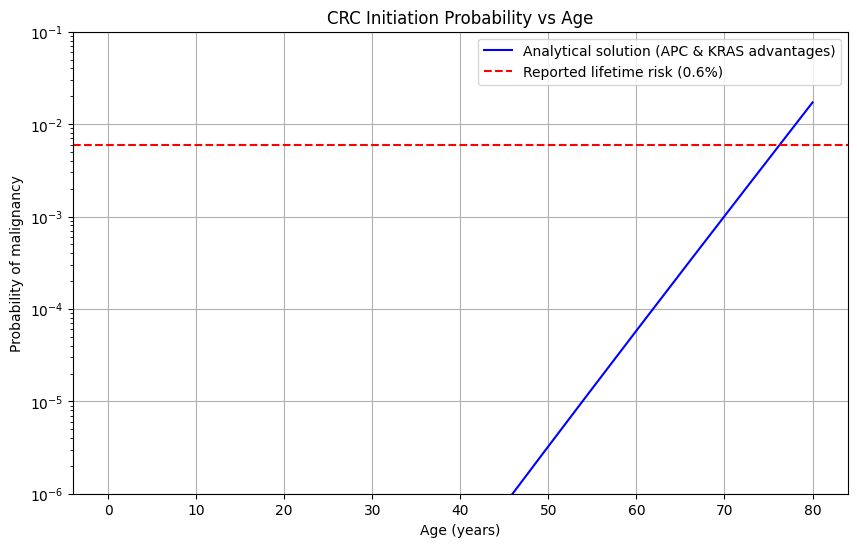

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_probability(t: float) -> float:
    """
    Calculate probability using equation 3 from the paper
    P(t) ≈ cNr_APC r_TP53 r_KRAS r_LOH^2 * t * exp(b12*t) * 
    (1/(b12^3(b12-b1)) + 1/(b12^3(b12-b2)) + 1/(b12^2(b12-b2)^2))
    """
    # Parameters from paper
    N = 1e8  # Number of crypts
    
    # Mutation rates per year
    r_APC = 604 * 1.25e-8
    r_TP53 = 73 * 1.25e-8
    r_KRAS = 20 * 1.25e-8
    r_LOH = 1.36e-4
    
    # Growth rates per year
    b1 = 0.2    # APC-/- division rate
    b2 = 0.07   # KRAS+ division rate
    b12 = b1 + b2
    
    # Correction factor
    c = 21.2  # Combined correction (5.88 * 3.6)
    
    # Calculate the three terms in parentheses
    term1 = 1/(b12**3 * (b12 - b1))
    term2 = 1/(b12**3 * (b12 - b2))
    term3 = 1/(b12**2 * (b12 - b2)**2)
    
    # Full probability calculation
    p = (c * N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * t * 
         np.exp(b12 * t) * (term1 + term2 + term3))
    
    return p

def plot_results():
    # Generate time points
    times = np.linspace(0, 80, 1000)
    
    # Calculate probabilities
    probs = []
    for t in times:
        p = calculate_probability(t)
        if p > 1:  # Cap probability at 1
            p = 1.0
        probs.append(p)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot analytical solution
    plt.plot(times, probs, 'b-', label='Analytical solution (APC & KRAS advantages)')
    
    # Add reference line for 0.6% lifetime risk
    plt.axhline(y=0.006, color='r', linestyle='--', label='Reported lifetime risk (0.6%)')
    
    plt.xlabel('Age (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('CRC Initiation Probability vs Age')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-6, 1e-1)
    
    # Print some values for debugging
    for t in [40, 60, 80]:
        p = calculate_probability(t)
        print(f"t={t}, p={p:.2e}")
    
    plt.show()

# Generate plot
plot_results()

Starting simulation...

Time 0.0: Malignant probability = 0.00e+00
Current state:
  wildtype: 1.00e+08
  APC_het: 6.62e+03
  KRAS_act: 5.00e+00

Time 80.0: Malignant probability = 0.00e+00
Current state:
  wildtype: 1.31e+06
  APC_het: 8.97e+04
  APC_null: 9.86e+07
  KRAS_act: 4.91e+03
  TP53_het: 3.74e+00
  APC_KRAS: 7.27e+03


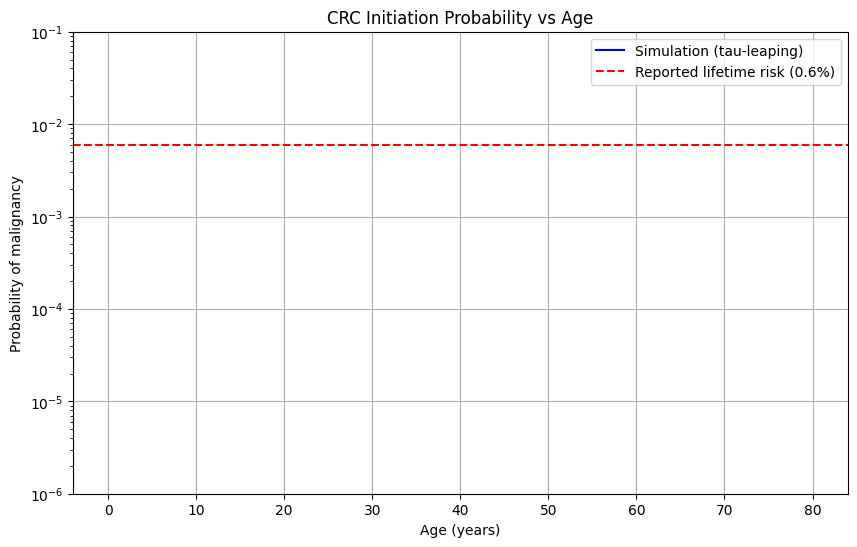

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

class CRCSimulation:
    def __init__(self):
        # Model parameters
        self.N = 10**8  # Number of crypts
        
        # Base mutation rate per bp per year, increased to match paper dynamics
        self.u = 1.25e-8
        
        # Calculate driver mutation rates (mutations per year)
        self.r_APC = 604 * self.u     # APC mutation rate
        self.r_TP53 = 73 * self.u     # TP53 mutation rate
        self.r_KRAS = 20 * self.u     # KRAS mutation rate
        self.r_LOH = 1.36e-4          # Loss of heterozygosity rate
        
        # Correction factors for mutation fixation
        self.c1 = 5.88  # APC fixation advantage
        self.c2 = 3.6   # KRAS fixation advantage
        
        # Growth rates per year
        self.b1 = 0.2    # APC-/- division rate
        self.b2 = 0.07   # KRAS+ division rate
        self.b12 = self.b1 + self.b2  # Combined rate
        
        # Initialize state dictionary
        self.state = {
            'wildtype': self.N,
            'APC_het': 0,      # APC+/-
            'APC_null': 0,     # APC-/-
            'KRAS_act': 0,     # KRAS+
            'TP53_het': 0,     # TP53+/-
            'TP53_null': 0,    # TP53-/-
            'APC_KRAS': 0,     # APC-/- KRAS+
            'malignant': 0     # All mutations
        }

    def calculate_propensities(self) -> Dict[str, float]:
        """Calculate propensities for all possible reactions"""
        props = {}
        
        # First-order reactions (mutations) with correction factors
        props['APC_first'] = self.state['wildtype'] * (self.r_APC + self.r_LOH) * self.c1
        props['APC_second'] = self.state['APC_het'] * (self.r_APC/2 + self.r_LOH/2) * self.c1
        props['KRAS'] = (self.state['wildtype'] + self.state['APC_null']) * self.r_KRAS * self.c2
        props['TP53_first'] = self.state['APC_KRAS'] * (self.r_TP53 + self.r_LOH)
        props['TP53_second'] = self.state['TP53_het'] * (self.r_TP53/2 + self.r_LOH/2)
        
        # Growth reactions
        if self.state['APC_null'] > 0:
            props['APC_null_growth'] = self.state['APC_null'] * self.b1
        if self.state['KRAS_act'] > 0:
            props['KRAS_growth'] = self.state['KRAS_act'] * self.b2
        if self.state['APC_KRAS'] > 0:
            props['combined_growth'] = self.state['APC_KRAS'] * self.b12
        
        return props

    def tau_leap(self, tau: float):
        """Perform one tau-leaping step"""
        props = self.calculate_propensities()
        changes = {key: 0 for key in self.state}
        
        for reaction, prop in props.items():
            # For very small propensities, use expected value instead of Poisson
            if prop * tau < 1e-10:
                events = prop * tau
            else:
                events = np.random.poisson(prop * tau)
            
            if events > 0:
                if reaction == 'APC_first':
                    max_events = min(events, self.state['wildtype'])
                    changes['wildtype'] -= max_events
                    changes['APC_het'] += max_events
                    
                elif reaction == 'APC_second':
                    max_events = min(events, self.state['APC_het'])
                    changes['APC_het'] -= max_events
                    changes['APC_null'] += max_events
                    
                elif reaction == 'KRAS':
                    # KRAS can activate in either wildtype or APC-null cells
                    total_available = self.state['wildtype'] + self.state['APC_null']
                    if total_available > 0:
                        max_events = min(events, total_available)
                        # Distribute events proportionally
                        apc_null_frac = self.state['APC_null'] / total_available
                        apc_null_events = int(max_events * apc_null_frac)
                        
                        changes['APC_null'] -= apc_null_events
                        changes['APC_KRAS'] += apc_null_events
                        
                        wt_events = max_events - apc_null_events
                        changes['wildtype'] -= wt_events
                        changes['KRAS_act'] += wt_events
                    
                elif reaction == 'TP53_first':
                    max_events = min(events, self.state['APC_KRAS'])
                    changes['APC_KRAS'] -= max_events
                    changes['TP53_het'] += max_events
                    
                elif reaction == 'TP53_second':
                    max_events = min(events, self.state['TP53_het'])
                    changes['TP53_het'] -= max_events
                    changes['malignant'] += max_events
                    
                elif reaction == 'APC_null_growth':
                    changes['APC_null'] += events
                elif reaction == 'KRAS_growth':
                    changes['KRAS_act'] += events
                elif reaction == 'combined_growth':
                    changes['APC_KRAS'] += events
        
        # Apply all changes
        for key in self.state:
            self.state[key] = max(0, self.state[key] + changes[key])
            
        # Ensure conservation of total population (within reasonable bounds)
        total = sum(self.state.values())
        if abs(total - self.N) > self.N * 0.01:  # Allow 1% variation
            scale_factor = self.N / total
            for key in self.state:
                self.state[key] *= scale_factor

    def run_simulation(self, max_time: float = 80, n_steps: int = 1000) -> Tuple[List[float], List[float]]:
        """Run the full simulation"""
        times = np.linspace(0, max_time, n_steps)
        tau = max_time / n_steps
        probabilities = []
        
        for t in times:
            self.tau_leap(tau)
            
            # Calculate probability of malignancy
            p_malignant = 1 - np.exp(-self.state['malignant'] / self.N)
            probabilities.append(p_malignant)
            
            if t % 10 == 0:
                print(f"\nTime {t:.1f}: Malignant probability = {p_malignant:.2e}")
                print("Current state:")
                for key, value in self.state.items():
                    if value > 0:
                        print(f"  {key}: {value:.2e}")
        
        return times.tolist(), probabilities

def plot_results(times: List[float], probs: List[float]):
    """Plot simulation results"""
    plt.figure(figsize=(10, 6))
    
    plt.plot(times, probs, 'b-', label='Simulation (tau-leaping)')
    plt.axhline(y=0.006, color='r', linestyle='--', label='Reported lifetime risk (0.6%)')
    
    plt.xlabel('Age (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('CRC Initiation Probability vs Age')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-6, 1e-1)
    
    plt.show()

# Run simulation
print("Starting simulation...")
sim = CRCSimulation()
times, probabilities = sim.run_simulation()
plot_results(times, probabilities)

Starting simulation...

Time 0.0: Malignant probability = 0.00e+00
Current state:
  wildtype: 1.00e+08
  APC_het: 6.71e+03
  KRAS_act: 1.10e+01

Time 80.0: Malignant probability = 0.00e+00
Current state:
  wildtype: 1.34e+06
  APC_het: 9.23e+04
  APC_null: 9.86e+07
  KRAS_act: 4.56e+03
  APC_KRAS: 7.46e+03


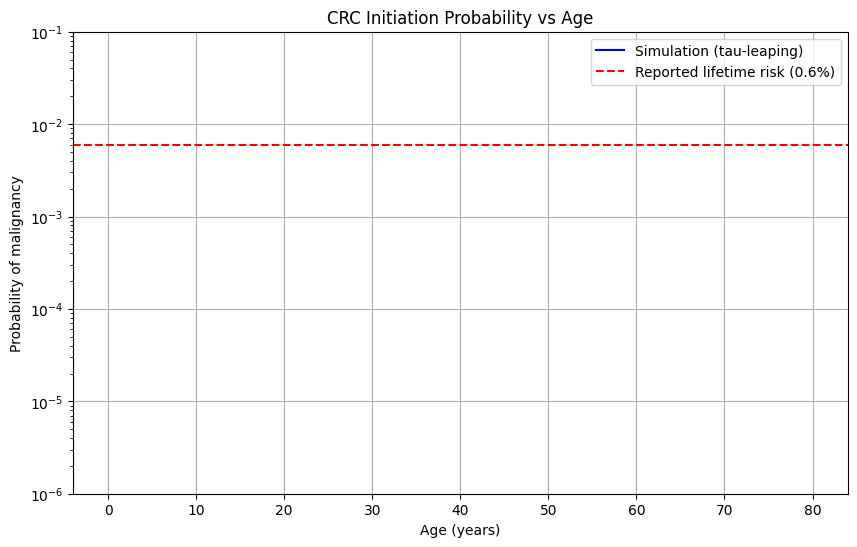

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

class CRCSimulation:
    def __init__(self):
        # Model parameters
        self.N = 10**8  # Number of crypts
        
        # Base mutation rate per bp per year, increased to match paper dynamics
        self.u = 1.25e-8
        
        # Calculate driver mutation rates (mutations per year)
        self.r_APC = 604 * self.u     # APC mutation rate
        self.r_TP53 = 73 * self.u     # TP53 mutation rate
        self.r_KRAS = 20 * self.u     # KRAS mutation rate
        self.r_LOH = 1.36e-4          # Loss of heterozygosity rate
        
        # Correction factors for mutation fixation
        self.c1 = 5.88  # APC fixation advantage
        self.c2 = 3.6   # KRAS fixation advantage
        
        # Growth rates per year
        self.b1 = 0.2    # APC-/- division rate
        self.b2 = 0.07   # KRAS+ division rate
        self.b12 = self.b1 + self.b2  # Combined rate
        
        # Initialize state dictionary
        self.state = {
            'wildtype': self.N,
            'APC_het': 0,      # APC+/-
            'APC_null': 0,     # APC-/-
            'KRAS_act': 0,     # KRAS+
            'TP53_het': 0,     # TP53+/-
            'TP53_null': 0,    # TP53-/-
            'APC_KRAS': 0,     # APC-/- KRAS+
            'malignant': 0     # All mutations
        }

    def calculate_propensities(self) -> Dict[str, float]:
        """Calculate propensities for all possible reactions"""
        props = {}
        
        # First-order reactions (mutations) with correction factors
        props['APC_first'] = self.state['wildtype'] * (self.r_APC + self.r_LOH) * self.c1
        props['APC_second'] = self.state['APC_het'] * (self.r_APC/2 + self.r_LOH/2) * self.c1
        props['KRAS'] = (self.state['wildtype'] + self.state['APC_null']) * self.r_KRAS * self.c2
        props['TP53_first'] = self.state['APC_KRAS'] * (self.r_TP53 + self.r_LOH)
        props['TP53_second'] = self.state['TP53_het'] * (self.r_TP53/2 + self.r_LOH/2)
        
        # Growth reactions
        props['APC_null_growth'] = self.state['APC_null'] * self.b1 if self.state['APC_null'] > 0 else 0
        props['KRAS_growth'] = self.state['KRAS_act'] * self.b2 if self.state['KRAS_act'] > 0 else 0
        props['combined_growth'] = self.state['APC_KRAS'] * self.b12 if self.state['APC_KRAS'] > 0 else 0
        
        return props

    def tau_leap(self, tau: float):
        """Perform one tau-leaping step"""
        props = self.calculate_propensities()
        changes = {key: 0 for key in self.state}
        
        for reaction, prop in props.items():
            # For very small propensities, use expected value instead of Poisson
            if prop * tau < 1e-15:
                events = prop * tau
            else:
                events = np.random.poisson(prop * tau)
            
            if events > 0:
                if reaction == 'APC_first':
                    max_events = min(events, self.state['wildtype'])
                    changes['wildtype'] -= max_events
                    changes['APC_het'] += max_events
                    
                elif reaction == 'APC_second':
                    max_events = min(events, self.state['APC_het'])
                    changes['APC_het'] -= max_events
                    changes['APC_null'] += max_events
                    
                elif reaction == 'KRAS':
                    total_available = self.state['wildtype'] + self.state['APC_null']
                    if total_available > 0:
                        max_events = min(events, total_available)
                        apc_null_frac = self.state['APC_null'] / total_available
                        apc_null_events = int(max_events * apc_null_frac)
                        
                        changes['APC_null'] -= apc_null_events
                        changes['APC_KRAS'] += apc_null_events
                        
                        wt_events = max_events - apc_null_events
                        changes['wildtype'] -= wt_events
                        changes['KRAS_act'] += wt_events
                    
                elif reaction == 'TP53_first':
                    max_events = min(events, self.state['APC_KRAS'])
                    changes['APC_KRAS'] -= max_events
                    changes['TP53_het'] += max_events
                    
                elif reaction == 'TP53_second':
                    max_events = min(events, self.state['TP53_het'])
                    changes['TP53_het'] -= max_events
                    changes['malignant'] += max_events
                    
                elif reaction == 'APC_null_growth':
                    changes['APC_null'] += events
                elif reaction == 'KRAS_growth':
                    changes['KRAS_act'] += events
                elif reaction == 'combined_growth':
                    changes['APC_KRAS'] += events
        
        # Apply all changes
        for key in self.state:
            self.state[key] = max(0, self.state[key] + changes[key])
            
        # Ensure conservation of total population (within reasonable bounds)
        total = sum(self.state.values())
        if abs(total - self.N) > self.N * 0.01:  # Allow 1% variation
            scale_factor = self.N / total
            for key in self.state:
                self.state[key] = int(self.state[key] * scale_factor)

    def run_simulation(self, max_time: float = 80, n_steps: int = 1000) -> Tuple[List[float], List[float]]:
        """Run the full simulation"""
        times = np.linspace(0, max_time, n_steps)
        tau = max_time / n_steps
        probabilities = []
        
        for t in times:
            self.tau_leap(tau)
            
            # Calculate probability of malignancy
            p_malignant = 1 - np.exp(-self.state['malignant'] / self.N)
            probabilities.append(p_malignant)
            
            if t % 10 == 0:  # Log every 10 years
                print(f"\nTime {t:.1f}: Malignant probability = {p_malignant:.2e}")
                print("Current state:")
                for key, value in self.state.items():
                    if value > 0:
                        print(f"  {key}: {value:.2e}")
        
        return times.tolist(), probabilities

def plot_results(times: List[float], probs: List[float]):
    """Plot simulation results"""
    plt.figure(figsize=(10, 6))
    
    plt.plot(times, probs, 'b-', label='Simulation (tau-leaping)')
    plt.axhline(y=0.006, color='r', linestyle='--', label='Reported lifetime risk (0.6%)')
    
    plt.xlabel('Age (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('CRC Initiation Probability vs Age')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-6, 1e-1)
    
    plt.show()

# Run simulation
print("Starting simulation...")
sim = CRCSimulation()
times, probabilities = sim.run_simulation()
plot_results(times, probabilities)


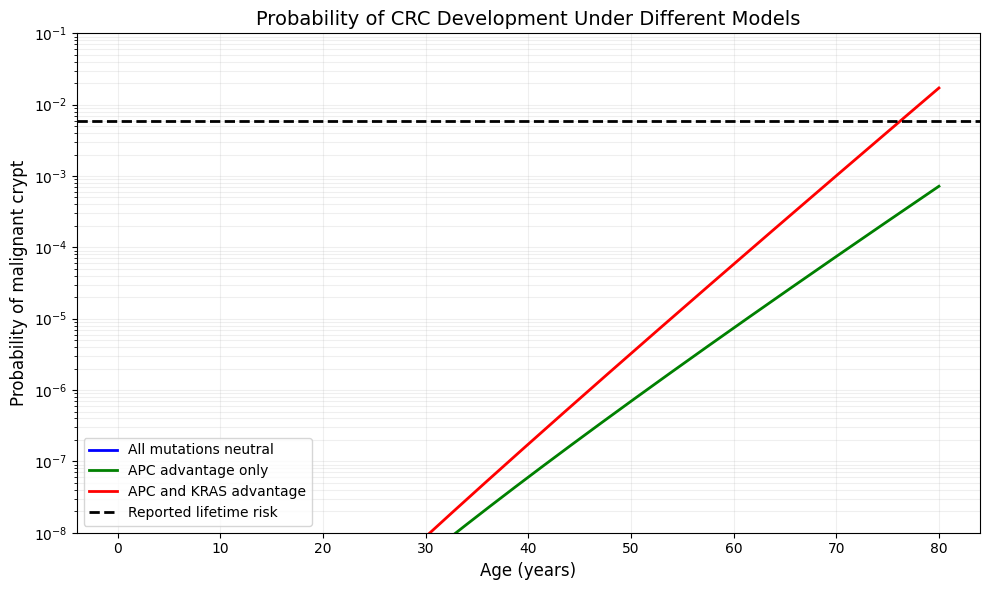

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Constants from the paper
def get_parameters():
    """Return the parameters used in the model"""
    # Number of crypts
    N = 1e8
    
    # Base mutation rate per base pair per year
    u = 1.25e-8
    
    # Number of driver positions in each gene
    n_APC = 604
    n_TP53 = 73
    n_KRAS = 20
    
    # Gene-specific mutation rates per year
    r_APC = n_APC * u
    r_TP53 = n_TP53 * u
    r_KRAS = n_KRAS * u
    
    # Rate of LOH (loss of heterozygosity)
    r_LOH = 1.36e-4
    
    # Division rates per year
    b1 = 0.2  # APC-/- crypts
    b2 = 0.07  # KRAS+ crypts
    b12 = b1 + b2  # Double mutant APC-/-KRAS+ crypts
    
    # Correction factors for increased fixation
    c1 = 5.88  # APC correction
    c2 = 3.6   # KRAS correction
    c = c1 * c2  # Total correction
    
    return N, r_APC, r_TP53, r_KRAS, r_LOH, b1, b2, b12, c

def neutral_probability(t):
    """Calculate probability when all mutations are neutral (Equation 1)"""
    N, r_APC, r_TP53, r_KRAS, r_LOH, _, _, _, _ = get_parameters()
    
    return N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * t**5 / 4

def apc_advantage_probability(t):
    """Calculate probability when only APC provides advantage (Equation 2)"""
    N, r_APC, r_TP53, r_KRAS, r_LOH, b1, _, _, c1 = get_parameters()
    
    return (3 * N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * np.exp(b1 * t) * t**2) / (2 * b1**3) * c1

def apc_kras_advantage_probability(t):
    """Calculate probability when both APC and KRAS provide advantage (Equation 3)"""
    N, r_APC, r_TP53, r_KRAS, r_LOH, b1, b2, b12, c = get_parameters()
    
    term1 = 1 / (b12**3 * (b12 - b1))
    term2 = 1 / (b12**3 * (b12 - b2))
    term3 = 1 / (b12**2 * (b12 - b2)**2)
    
    return c * N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * t * np.exp(b12 * t) * (term1 + term2 + term3)

def plot_probabilities():
    """Create plot similar to Figure 2 from the paper"""
    # Set the figure style
    plt.style.use('default')
    
    # Create figure with a white background
    plt.figure(figsize=(10, 6), facecolor='white')
    
    # Create time points (0 to 80 years)
    t = np.linspace(0, 80, 1000)
    
    # Calculate probabilities
    p_neutral = [neutral_probability(ti) for ti in t]
    p_apc = [apc_advantage_probability(ti) for ti in t]
    p_both = [apc_kras_advantage_probability(ti) for ti in t]
    
    # Create the plot
    plt.semilogy(t, p_neutral, 'b-', label='All mutations neutral', linewidth=2)
    plt.semilogy(t, p_apc, 'g-', label='APC advantage only', linewidth=2)
    plt.semilogy(t, p_both, 'r-', label='APC and KRAS advantage', linewidth=2)
    
    # Add reported lifetime risk line
    plt.axhline(y=0.006, color='k', linestyle='--', label='Reported lifetime risk', linewidth=2)
    
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Probability of malignant crypt', fontsize=12)
    plt.title('Probability of CRC Development Under Different Models', fontsize=14)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=10)
    plt.ylim(1e-8, 1e-1)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Generate and show the plot
plot_probabilities()
plt.show()

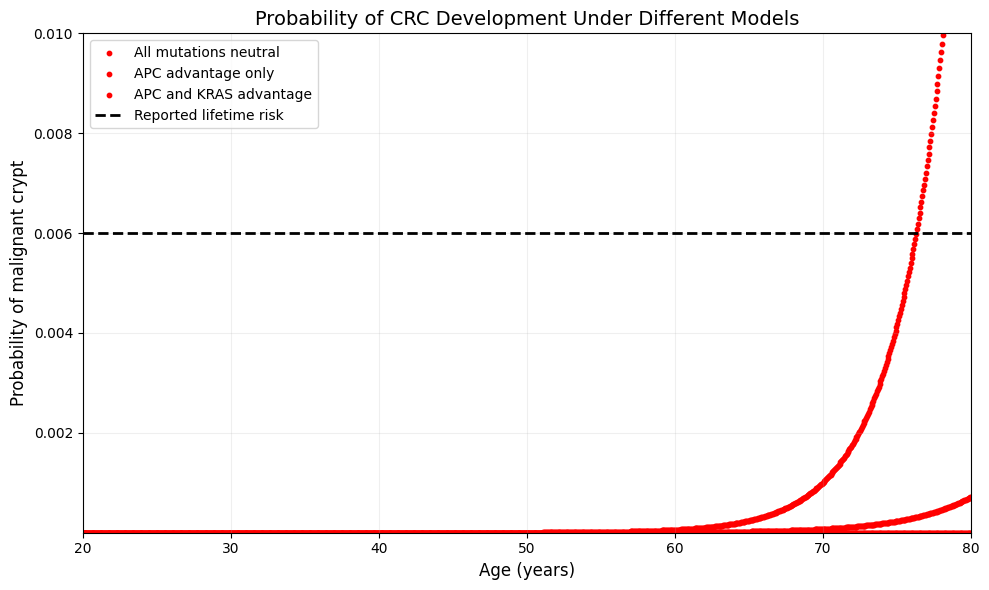

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Constants from the paper
def get_parameters():
    """Return the parameters used in the model"""
    # Number of crypts
    N = 1e8
    
    # Base mutation rate per base pair per year
    u = 1.25e-8
    
    # Number of driver positions in each gene
    n_APC = 604
    n_TP53 = 73
    n_KRAS = 20
    
    # Gene-specific mutation rates per year
    r_APC = n_APC * u
    r_TP53 = n_TP53 * u
    r_KRAS = n_KRAS * u
    
    # Rate of LOH (loss of heterozygosity)
    r_LOH = 1.36e-4
    
    # Division rates per year
    b1 = 0.2  # APC-/- crypts
    b2 = 0.07  # KRAS+ crypts
    b12 = b1 + b2  # Double mutant APC-/-KRAS+ crypts
    
    # Correction factors for increased fixation
    c1 = 5.88  # APC correction
    c2 = 3.6   # KRAS correction
    c = c1 * c2  # Total correction
    
    return N, r_APC, r_TP53, r_KRAS, r_LOH, b1, b2, b12, c

def neutral_probability(t):
    """Calculate probability when all mutations are neutral (Equation 1)"""
    N, r_APC, r_TP53, r_KRAS, r_LOH, _, _, _, _ = get_parameters()
    return N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * t**5 / 4

def apc_advantage_probability(t):
    """Calculate probability when only APC provides advantage (Equation 2)"""
    N, r_APC, r_TP53, r_KRAS, r_LOH, b1, _, _, c1 = get_parameters()
    return (3 * N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * np.exp(b1 * t) * t**2) / (2 * b1**3) * c1

def apc_kras_advantage_probability(t):
    """Calculate probability when both APC and KRAS provide advantage (Equation 3)"""
    N, r_APC, r_TP53, r_KRAS, r_LOH, b1, b2, b12, c = get_parameters()
    term1 = 1 / (b12**3 * (b12 - b1))
    term2 = 1 / (b12**3 * (b12 - b2))
    term3 = 1 / (b12**2 * (b12 - b2)**2)
    return c * N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * t * np.exp(b12 * t) * (term1 + term2 + term3)

def plot_probabilities():
    """Create plot similar to Figure 2 from the paper"""
    # Set the figure style
    plt.style.use('default')
    
    # Create figure with a white background
    plt.figure(figsize=(10, 6), facecolor='white')
    
    # Create time points (20 to 80 years)
    t = np.linspace(20, 80, 1000)
    
    # Calculate probabilities
    p_neutral = [neutral_probability(ti) for ti in t]
    p_apc = [apc_advantage_probability(ti) for ti in t]
    p_both = [apc_kras_advantage_probability(ti) for ti in t]
    
    # Create the plot with red points
    plt.scatter(t, p_neutral, color='red', label='All mutations neutral', s=10)
    plt.scatter(t, p_apc, color='red', label='APC advantage only', s=10)
    plt.scatter(t, p_both, color='red', label='APC and KRAS advantage', s=10)
    
    # Add reported lifetime risk line
    plt.axhline(y=0.006, color='k', linestyle='--', label='Reported lifetime risk', linewidth=2)
    
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Probability of malignant crypt', fontsize=12)
    plt.title('Probability of CRC Development Under Different Models', fontsize=14)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=10)
    plt.ylim(1e-11, 0.01)
    plt.xlim(20, 80)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Generate and show the plot
plot_probabilities()
plt.show()


Calculating analytical solution...

Probabilities at key ages:
Age 40: 1.75e-07
Age 60: 5.82e-05
Age 80: 1.72e-02


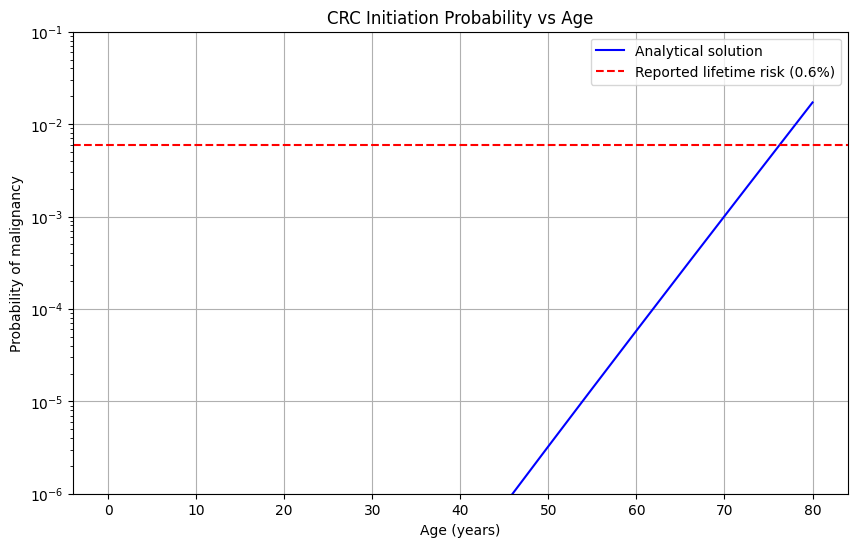

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_analytical_probability(t: float) -> float:
    """
    Calculate probability using equation 3 from the paper:
    P(t) ≈ cNr_APC r_TP53 r_KRAS r_LOH^2 * t * exp(b12*t) * 
    (1/(b12^3(b12-b1)) + 1/(b12^3(b12-b2)) + 1/(b12^2(b12-b2)^2))
    """
    # Parameters from paper
    N = 1e8           # Number of crypts
    u = 1.25e-8      # Base mutation rate
    
    # Mutation rates
    r_APC = 604 * u  # APC mutation rate
    r_TP53 = 73 * u  # TP53 mutation rate
    r_KRAS = 20 * u  # KRAS mutation rate
    r_LOH = 1.36e-4  # Loss of heterozygosity rate
    
    # Growth rates
    b1 = 0.2     # APC-/- division rate
    b2 = 0.07    # KRAS+ division rate
    b12 = b1 + b2  # Combined rate
    
    # Correction factors
    c = 21.2  # Combined correction (5.88 * 3.6)
    
    # Calculate the three terms in parentheses
    term1 = 1/(b12**3 * (b12 - b1))
    term2 = 1/(b12**3 * (b12 - b2))
    term3 = 1/(b12**2 * (b12 - b2)**2)
    
    # Full probability calculation
    p = (c * N * r_APC * r_TP53 * r_KRAS * r_LOH**2 * t * 
         np.exp(b12 * t) * (term1 + term2 + term3))
    
    return min(p, 1.0)  # Cap probability at 1

def plot_analytical_solution():
    """Plot analytical solution from paper"""
    # Generate time points
    times = np.linspace(0, 80, 1000)
    
    # Calculate probabilities
    probs = [calculate_analytical_probability(t) for t in times]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    plt.plot(times, probs, 'b-', label='Analytical solution')
    plt.axhline(y=0.006, color='r', linestyle='--', label='Reported lifetime risk (0.6%)')
    
    plt.xlabel('Age (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('CRC Initiation Probability vs Age')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-6, 1e-1)
    
    # Print some key values
    key_ages = [40, 60, 80]
    print("\nProbabilities at key ages:")
    for age in key_ages:
        p = calculate_analytical_probability(age)
        print(f"Age {age}: {p:.2e}")
    
    plt.show()

# Generate plot of analytical solution
print("Calculating analytical solution...")
plot_analytical_solution()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

class CRCSimulation:
    def __init__(self):
        # Model parameters
        self.N = 10**8  # Number of crypts
        
        # Base mutation rate per bp per year
        self.u = 1.25e-8
        
        # Correction factors
        self.c1 = 5.88  # APC fixation advantage
        self.c2 = 3.6   # KRAS fixation advantage
        
        # Mutation rates enhanced by correction factors
        self.r_APC = 604 * self.u * self.c1    # APC mutation rate
        self.r_TP53 = 73 * self.u              # TP53 mutation rate
        self.r_KRAS = 20 * self.u * self.c2    # KRAS mutation rate
        self.r_LOH = 1.36e-4 * self.c1         # LOH rate
        
        # Growth rates per year
        self.b1 = 0.2    # APC-/- division rate
        self.b2 = 0.07   # KRAS+ division rate
        self.b12 = 0.27  # Combined rate
        
        # Initialize state vector
        self.state = np.zeros(7, dtype=np.int64)
        self.state[0] = self.N  # All cells start as wildtype
        
        # State indices
        self.WILD = 0    # Wildtype
        self.APC1 = 1    # APC+/-
        self.APC2 = 2    # APC-/-
        self.KRAS = 3    # KRAS+
        self.TP53 = 4    # TP53+/-
        self.APCK = 5    # APC-/- KRAS+
        self.MALI = 6    # Malignant

    def calculate_propensities(self) -> np.ndarray:
        """Calculate propensities for all reactions"""
        props = np.zeros(12)
        
        # APC mutations
        props[0] = self.state[self.WILD] * (self.r_APC + self.r_LOH)  # First APC hit
        props[1] = self.state[self.APC1] * (self.r_APC/2 + self.r_LOH/2)  # Second APC hit
        
        # KRAS mutations
        props[2] = self.state[self.WILD] * self.r_KRAS  # KRAS in wildtype
        props[3] = self.state[self.APC2] * self.r_KRAS  # KRAS in APC-/-
        
        # TP53 mutations
        props[4] = self.state[self.APCK] * (self.r_TP53 + self.r_LOH)  # First TP53 hit
        props[5] = self.state[self.TP53] * (self.r_TP53/2 + self.r_LOH/2)  # Second TP53 hit
        
        # Growth reactions
        props[6] = self.state[self.APC2] * self.b1  # APC-/- growth
        props[7] = self.state[self.KRAS] * self.b2  # KRAS+ growth
        props[8] = self.state[self.APCK] * self.b12  # Combined growth
        
        return props

    def gillespie_step(self) -> float:
        """Perform one step of the Gillespie algorithm"""
        props = self.calculate_propensities()
        total_prop = np.sum(props)
        
        if total_prop == 0:
            return np.inf
        
        # Time until next reaction
        dt = np.random.exponential(1/total_prop)
        
        # Choose reaction
        reaction = np.random.choice(len(props), p=props/total_prop)
        
        # Update state based on reaction
        if reaction == 0:  # First APC hit
            self.state[self.WILD] -= 1
            self.state[self.APC1] += 1
        elif reaction == 1:  # Second APC hit
            self.state[self.APC1] -= 1
            self.state[self.APC2] += 1
        elif reaction == 2:  # KRAS in wildtype
            self.state[self.WILD] -= 1
            self.state[self.KRAS] += 1
        elif reaction == 3:  # KRAS in APC-/-
            self.state[self.APC2] -= 1
            self.state[self.APCK] += 1
        elif reaction == 4:  # First TP53 hit
            self.state[self.APCK] -= 1
            self.state[self.TP53] += 1
        elif reaction == 5:  # Second TP53 hit (malignant)
            self.state[self.TP53] -= 1
            self.state[self.MALI] += 1
        elif reaction == 6:  # APC-/- growth
            self.state[self.APC2] += 1
        elif reaction == 7:  # KRAS+ growth
            self.state[self.KRAS] += 1
        elif reaction == 8:  # Combined growth
            self.state[self.APCK] += 1
            
        return dt

    def run_simulation(self, max_time: float = 80) -> Tuple[List[float], List[float]]:
        """Run the simulation using Gillespie algorithm"""
        times = [0.0]
        probabilities = [0.0]
        current_time = 0.0
        
        while current_time < max_time:
            dt = self.gillespie_step()
            current_time += dt
            
            if current_time >= max_time:
                break
                
            times.append(current_time)
            p_malignant = 1 - np.exp(-self.state[self.MALI] / self.N)
            probabilities.append(p_malignant)
            
            if int(current_time) % 10 == 0 and int(current_time) != int(current_time - dt):
                print(f"\nTime {current_time:.1f}: Malignant probability = {p_malignant:.2e}")
                print("Current state:")
                state_names = ['Wildtype', 'APC+/-', 'APC-/-', 'KRAS+', 'TP53+/-', 'APC-/-,KRAS+', 'Malignant']
                for i, (name, value) in enumerate(zip(state_names, self.state)):
                    if value > 0:
                        print(f"  {name}: {value:.2e}")
        
        return times, probabilities

def plot_results(times: List[float], probs: List[float]):
    """Plot simulation results"""
    plt.figure(figsize=(10, 6))
    
    plt.plot(times, probs, 'b-', label='Simulation (Gillespie)')
    plt.axhline(y=0.006, color='r', linestyle='--', label='Reported lifetime risk (0.6%)')
    
    plt.xlabel('Age (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('CRC Initiation Probability vs Age')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-6, 1e-1)
    
    plt.show()

# Run simulation
print("Starting simulation...")
sim = CRCSimulation()
times, probabilities = sim.run_simulation()
plot_results(times, probabilities)

Starting simulation...

Time 10.0: Malignant probability = 0.00e+00
Current state:
  Wildtype: 9.92e+07
  APC+/-: 8.38e+05
  APC-/-: 4.06e+03
  KRAS+: 1.34e+03

Time 20.0: Malignant probability = 0.00e+00
Current state:
  Wildtype: 9.83e+07
  APC+/-: 1.67e+06
  APC-/-: 4.47e+04
  KRAS+: 3.98e+03

Time 30.0: Malignant probability = 0.00e+00
Current state:
  Wildtype: 9.75e+07
  APC+/-: 2.48e+06
  APC-/-: 3.57e+05
  KRAS+: 9.22e+03
  APC-/-,KRAS+: 6.00e+00

Time 40.0: Malignant probability = 0.00e+00
Current state:
  Wildtype: 9.67e+07
  APC+/-: 3.29e+06
  APC-/-: 2.68e+06
  KRAS+: 1.98e+04
  TP53+/-: 3.00e+00
  APC-/-,KRAS+: 1.20e+02

Time 50.0: Malignant probability = 0.00e+00
Current state:
  Wildtype: 9.59e+07
  APC+/-: 4.09e+06
  APC-/-: 1.98e+07
  KRAS+: 4.11e+04
  TP53+/-: 9.00e+00
  APC-/-,KRAS+: 1.92e+03


Run 0/100000
Run 100/100000
Run 200/100000
Run 300/100000
Run 400/100000
Run 500/100000
Run 600/100000
Run 700/100000
Run 800/100000
Run 900/100000
Run 1000/100000
Run 1100/100000
Run 1200/100000
Run 1300/100000
Run 1400/100000
Run 1500/100000
Run 1600/100000
Run 1700/100000
Run 1800/100000
Run 1900/100000
Run 2000/100000
Run 2100/100000
Run 2200/100000
Run 2300/100000
Run 2400/100000
Run 2500/100000
Run 2600/100000
Run 2700/100000
Run 2800/100000
Run 2900/100000
Run 3000/100000
Run 3100/100000
Run 3200/100000
Run 3300/100000
Run 3400/100000
Run 3500/100000
Run 3600/100000
Run 3700/100000
Run 3800/100000
Run 3900/100000
Run 4000/100000
Run 4100/100000
Run 4200/100000
Run 4300/100000
Run 4400/100000
Run 4500/100000
Run 4600/100000
Run 4700/100000
Run 4800/100000
Run 4900/100000
Run 5000/100000
Run 5100/100000
Run 5200/100000
Run 5300/100000
Run 5400/100000
Run 5500/100000
Run 5600/100000
Run 5700/100000
Run 5800/100000
Run 5900/100000
Run 6000/100000
Run 6100/100000
Run 6200/100000
Run 

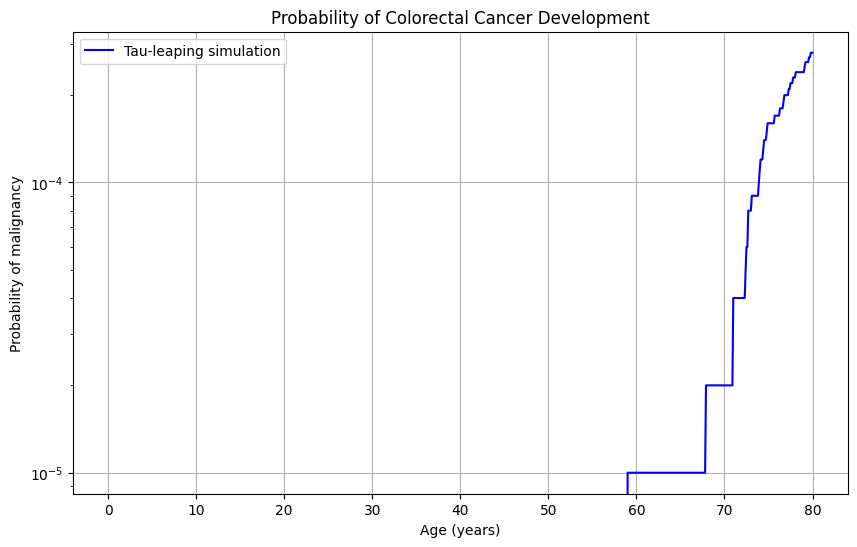

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Set, Tuple
import random

@dataclass
class SimParams:
    # Base mutation rate per base pair per year
    u: float = 1.25e-8
    
    # Number of driver positions in each gene
    n_APC: int = 604    # Number of APC driver positions
    n_TP53: int = 73    # Number of TP53 driver positions
    n_KRAS: int = 20    # Number of KRAS driver positions
    
    # Derived mutation rates per year
    r_APC: float = 604 * 1.25e-8    # APC mutation rate
    r_TP53: float = 73 * 1.25e-8    # TP53 mutation rate
    r_KRAS: float = 20 * 1.25e-8    # KRAS mutation rate
    r_LOH: float = 1.36e-4          # Rate of loss of heterozygosity
    
    # Division rates per year  
    b_APC: float = 0.2     # Division rate for APC-/- crypts
    b_KRAS: float = 0.07   # Division rate for KRAS+ crypts
    b_BOTH: float = 0.27   # Division rate for APC-/-,KRAS+ crypts (b_APC + b_KRAS)
    
    # Time parameters
    dt: float = 0.01      # Time step size (tau)
    t_max: float = 80.0   # Maximum simulation time
    
    # Initial conditions
    N_crypts: int = 10**8  # Number of initial crypts

class State:
    """Represents the genetic state of a crypt"""
    def __init__(self, APC: int, TP53: int, KRAS: int):
        # APC states:
        # 0: Wild type
        # 1: First hit LOH
        # 2: First hit mutation
        # 3: Second hit after LOH or mutation
        # 4: Double mutation
        self.APC = APC   
        
        # TP53 states: similar to APC
        self.TP53 = TP53 
        
        # KRAS states:
        # 0: Wild type
        # 1: Activated
        self.KRAS = KRAS
        
    def __hash__(self):
        return hash((self.APC, self.TP53, self.KRAS))
    
    def __eq__(self, other):
        return (self.APC, self.TP53, self.KRAS) == (other.APC, other.TP53, other.KRAS)
    
    def is_malignant(self):
        """Check if state represents a malignant crypt"""
        # Malignant states: (3,3,1), (3,4,1), (4,3,1), (4,4,1)
        return ((self.APC >= 3) and (self.TP53 >= 3) and (self.KRAS == 1))

def get_transition_rate(source: State, target: State, params: SimParams) -> float:
    """Calculate transition rate between states based on Supplementary Materials"""
    # APC transitions
    if target.APC > source.APC:
        if source.APC == 0:
            # First hit can be LOH or mutation
            return params.r_LOH if target.APC == 1 else params.r_APC
        elif source.APC == 1:
            # After LOH, only mutation possible
            return params.r_APC / 2
        elif source.APC == 2:
            # After mutation, both LOH and mutation possible
            return params.r_LOH / 2 if target.APC == 3 else params.r_APC / 2
            
    # TP53 transitions (similar to APC)
    if target.TP53 > source.TP53:
        if source.TP53 == 0:
            return params.r_LOH if target.TP53 == 1 else params.r_TP53
        elif source.TP53 == 1:
            return params.r_TP53 / 2
        elif source.TP53 == 2:
            return params.r_LOH / 2 if target.TP53 == 3 else params.r_TP53 / 2
            
    # KRAS activation
    if target.KRAS > source.KRAS:
        return params.r_KRAS
        
    return 0.0

def get_division_rate(state: State, params: SimParams) -> float:
    """Get division rate for a given state based on Supplementary Materials"""
    if state.APC >= 3:  # APC-/-
        if state.KRAS == 1:  # Also KRAS+
            return params.b_BOTH
        return params.b_APC
    elif state.KRAS == 1:  # Only KRAS+
        return params.b_KRAS
    return 0.0

def get_neighbors(state: State) -> Set[State]:
    """Get all possible next states from current state"""
    neighbors = set()
    
    # APC transitions
    if state.APC == 0:
        neighbors.add(State(1, state.TP53, state.KRAS))  # LOH
        neighbors.add(State(2, state.TP53, state.KRAS))  # Mutation
    elif state.APC == 1:
        neighbors.add(State(3, state.TP53, state.KRAS))  # Mutation after LOH
    elif state.APC == 2:
        neighbors.add(State(3, state.TP53, state.KRAS))  # LOH after mutation
        neighbors.add(State(4, state.TP53, state.KRAS))  # Second mutation
        
    # TP53 transitions
    if state.TP53 == 0:
        neighbors.add(State(state.APC, 1, state.KRAS))  # LOH
        neighbors.add(State(state.APC, 2, state.KRAS))  # Mutation
    elif state.TP53 == 1:
        neighbors.add(State(state.APC, 3, state.KRAS))  # Mutation after LOH
    elif state.TP53 == 2:
        neighbors.add(State(state.APC, 3, state.KRAS))  # LOH after mutation
        neighbors.add(State(state.APC, 4, state.KRAS))  # Second mutation
        
    # KRAS activation
    if state.KRAS == 0:
        neighbors.add(State(state.APC, state.TP53, 1))
        
    return neighbors

def tau_leaping_simulation(params: SimParams, n_runs: int = 1000) -> np.ndarray:
    """Run multiple tau-leaping simulations following supplementary materials"""
    time_points = np.arange(0, params.t_max + params.dt, params.dt)
    malignant_counts = np.zeros(len(time_points))
    
    for run in range(n_runs):
        if run % 100 == 0:
            print(f"Run {run}/{n_runs}")
            
        # Initialize population dictionary
        population = {State(0,0,0): params.N_crypts}
        had_malignant = False
        
        for t_idx, t in enumerate(time_points):
            if had_malignant:
                malignant_counts[t_idx:] += 1
                break
                
            # Process each populated state
            new_events = {}
            for state, count in list(population.items()):
                if count == 0:
                    continue
                    
                # Check for division events (negative binomial distribution)
                division_rate = get_division_rate(state, params)
                if division_rate > 0:
                    p = np.exp(-division_rate * params.dt)
                    n_divisions = np.random.negative_binomial(count, p)
                    if n_divisions > 0:
                        new_events[state] = new_events.get(state, 0) + n_divisions
                
                # Check for transitions to neighbor states
                for neighbor in get_neighbors(state):
                    rate = get_transition_rate(state, neighbor, params)
                    if rate > 0:
                        # Use Poisson approximation for small rates
                        if rate * params.dt < 0.01:
                            n_transitions = np.random.poisson(rate * params.dt * count)
                        else:
                            # Use binomial for larger rates
                            p = 1 - np.exp(-rate * params.dt)
                            n_transitions = np.random.binomial(count, p)
                            
                        if n_transitions > 0:
                            new_events[state] = new_events.get(state, 0) - n_transitions
                            new_events[neighbor] = new_events.get(neighbor, 0) + n_transitions
                            
                            if neighbor.is_malignant():
                                had_malignant = True
                                break
            
            # Update population
            for state, delta in new_events.items():
                population[state] = population.get(state, 0) + delta
                if population[state] < 0:  # Sanity check
                    population[state] = 0
                    
            if had_malignant:
                malignant_counts[t_idx:] += 1
                break
    
    return malignant_counts / n_runs

def plot_results(time_points: np.ndarray, probabilities: np.ndarray):
    """Plot the probability of malignancy over time"""
    plt.figure(figsize=(10, 6))
    plt.semilogy(time_points, probabilities, 'b-', label='Tau-leaping simulation')
    plt.xlabel('Age (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('Probability of Colorectal Cancer Development')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run simulation
#if __name__ == "__main__":
#    params = SimParams()
#    time_points = np.arange(0, params.t_max + params.dt, params.dt)
#    probabilities = tau_leaping_simulation(params, n_runs=10000)
#    plot_results(time_points, probabilities)

params = SimParams(
    dt = 0.1,           # 5-year time steps
    t_max = 80.0,       # Full lifetime
    N_crypts = 10**8    # Optionally reduce initial crypts
)

# Run with fewer simulations
time_points = np.arange(0, params.t_max + params.dt, params.dt)
probabilities = tau_leaping_simulation(params, n_runs=100000)
plot_results(time_points, probabilities)